#Disparity estimation and filter training in pairs

Train AMA on the task of disparity estimation. Train two
pairs of filters, one after the other (first the model
with 2 filters, and then the model with 4 filters)

In [1]:
##############
#### IMPORT PACKAGES
##############
import scipy.io as spio
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [2]:
!pip install geotorch
import geotorch
!pip install git+https://github.com/dherrera1911/accuracy_maximization_analysis.git
from ama_library import *
!mkdir data
!wget -O ./data/ama_dsp_noiseless.mat https://www.dropbox.com/s/eec1917swc124qd/ama_dsp_noiseless.mat?dl=0

  Cloning https://github.com/dherrera1911/accuracy_maximization_analysis.git to /tmp/pip-req-build-d72j1ihp
  Running command git clone --filter=blob:none --quiet https://github.com/dherrera1911/accuracy_maximization_analysis.git /tmp/pip-req-build-d72j1ihp
  Resolved https://github.com/dherrera1911/accuracy_maximization_analysis.git to commit 7c076e526fc5d4595e1e8ad8e57f2af04516b527
  Preparing metadata (setup.py) ... done
  Created wheel for AMA: filename=AMA-0.1-py3-none-any.whl size=17406 sha256=477a3fc23a10ca7564d7d8e833542d3921f828250069c29027efe2b55e1c494e
  Stored in directory: /tmp/pip-ephem-wheel-cache-t4lbwmmu/wheels/29/03/b4/9cdd2264f87eabb776eb11a200ff32f560a7b6a6d472cd5147
Successfully built AMA
--2023-04-10 22:03:16--  https://www.dropbox.com/s/eec1917swc124qd/ama_dsp_noiseless.mat?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6019:18::a27d:412, 162.125.4.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6019:18::a27d:412|:443... connected.
HTTP 

In [3]:
import ama_library.ama_class as cl
import ama_library.utilities as au

In [4]:
##############
#### LOAD AMA DATA
##############
# Load ama struct from .mat file into Python
data = spio.loadmat('./data/ama_dsp_noiseless.mat')
# Extract contrast normalized, noisy stimulus
s = data.get("s")
s = torch.from_numpy(s)
s = s.transpose(0,1)
s = s.float()
# Extract the vector indicating category of each stimulus row
ctgInd = data.get("ctgInd")
ctgInd = torch.tensor(ctgInd)
ctgInd = ctgInd.flatten()
ctgInd = ctgInd-1       # convert to python indexing (subtract 1)
ctgInd = ctgInd.type(torch.LongTensor)  # convert to torch integer
# Extract the values of the latent variable
ctgVal = data.get("X")
ctgVal = torch.from_numpy(ctgVal)
ctgVal = ctgVal.flatten().float()
nPixels = int(s.shape[1]/2)

## TRAINING 2 PAIRS OF FILTERS WITHOUT FIXING ANY

In this part of the code, we train the model with 2 filters,
then add 2 new random filters, and continue training the
4 filters together. We want to see whether the first 2 filters
remain fixed through the second round of training.

In [5]:
##############
#### SET TRAINING PARAMETERS FOR FIRST PAIR OF FILTERS
##############
nFilt = 2   # Number of filters to use
pixelNoiseVar = 0.001  # Input pixel noise variance
respNoiseVar = 0.003  # Filter response noise variance
nEpochs = 30
lrGamma = 0.5   # multiplication factor for lr decay
lossFun = au.cross_entropy_loss()
#lossFun = au.kl_loss()
learningRate = 0.01
lrStepSize = 10
batchSize = 256

In [6]:
##############
####  TRAIN FIRST PAIR OF FILTERS
##############
# Define model
ama = cl.AMA(sAll=s, nFilt=nFilt, ctgInd=ctgInd, respNoiseVar=respNoiseVar,
        pixelCov=pixelNoiseVar, ctgVal=ctgVal, respCovPooling='pre-filter',
        filtNorm='broadband')

# Put data into Torch data loader tools
trainDataset = TensorDataset(s, ctgInd)
# Batch loading and other utilities 
trainDataLoader = DataLoader(trainDataset, batch_size=batchSize,
        shuffle=True)
# Set up optimizer
opt = torch.optim.Adam(ama.parameters(), lr=learningRate)  # Adam
# Make learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=lrStepSize,
        gamma=lrGamma)

Initial loss:  2.941462278366089
Epoch: 1 |  Training loss: 2.8853  |  Loss change: -0.0562
Epoch: 2 |  Training loss: 2.8838  |  Loss change: -0.0015
Epoch: 3 |  Training loss: 2.8846  |  Loss change: 0.0007
Epoch: 4 |  Training loss: 2.8843  |  Loss change: -0.0003
Epoch: 5 |  Training loss: 2.8841  |  Loss change: -0.0002
Epoch: 6 |  Training loss: 2.8838  |  Loss change: -0.0003
Epoch: 7 |  Training loss: 2.8843  |  Loss change: 0.0006
Epoch: 8 |  Training loss: 2.8839  |  Loss change: -0.0004
Epoch: 9 |  Training loss: 2.8842  |  Loss change: 0.0002
Epoch: 10 |  Training loss: 2.8842  |  Loss change: 0.0000
Epoch: 11 |  Training loss: 2.8838  |  Loss change: -0.0004
Epoch: 12 |  Training loss: 2.8839  |  Loss change: 0.0001
Epoch: 13 |  Training loss: 2.8843  |  Loss change: 0.0004
Epoch: 14 |  Training loss: 2.8835  |  Loss change: -0.0008
Epoch: 15 |  Training loss: 2.8839  |  Loss change: 0.0003
Epoch: 16 |  Training loss: 2.8835  |  Loss change: -0.0004
Epoch: 17 |  Training l

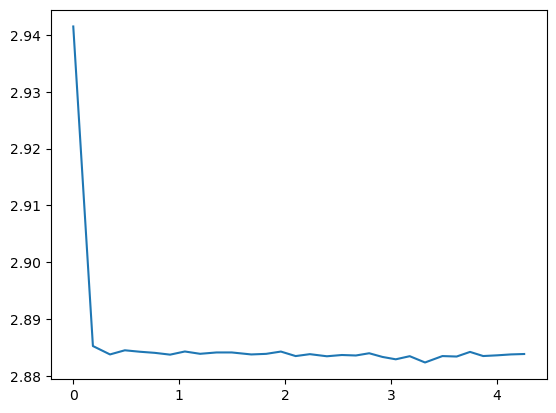

In [7]:
# fit model
loss, elapsedTimes = au.fit(nEpochs=nEpochs, model=ama,
        trainDataLoader=trainDataLoader, lossFun=lossFun, opt=opt,
        sAll=s, ctgInd=ctgInd, scheduler=scheduler)
plt.plot(elapsedTimes, loss)
plt.show()

In [8]:
## PLOT THE LEARNED FILTERS
x = np.linspace(start=-30, stop=30, num=ama.nDim) # x axis in arc min
au.view_all_filters_1D_bino_image(ama, x=x)
plt.show()

AttributeError: module 'ama_library.utilities' has no attribute 'view_all_filters_1D_bino_image'

In [ ]:
## ADD 2 NEW FILTERS
ama.add_new_filters(nFiltNew=2, sAll=s, ctgInd=ctgInd)

# Plot the set of 4 filters before re-training
au.view_all_filters_1D_bino_image(ama, x=x)
plt.show()

In [ ]:
## TRAIN THE NEW FILTERS TOGETHER WITH ORIGINAL
learningRate2 = learningRate * 1/3
nEpochs2 = 30
# Re-initializing the optimizer after adding filters is required
opt = torch.optim.Adam(ama.parameters(), lr=learningRate2)  # Adam
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=lrStepSize,
        gamma=lrGamma)
loss, elapsedTimes = au.fit(nEpochs=nEpochs2, model=ama,
        trainDataLoader=trainDataLoader, lossFun=lossFun, opt=opt,
        sAll=s, ctgInd=ctgInd, scheduler=scheduler)
plt.plot(elapsedTimes, loss)
plt.show()

# Plot filters after learning
au.view_all_filters_1D_bino_image(ama, x=x)
plt.show()

## TRAINING 2 PAIRS OF FILTERS, FIXING THE FIRST PAIR

In this part of the code, we train the model with 2 filters,
fix these filters so that they are no longer trainable, add
2 more filters, and then train these 2 new filters on top of
the original fixed ones. We aim to see how this procedure compares
to the training of different filters without fixing.

In [ ]:
# DEFINE NEW MODEL TO TRAIN
ama2 = cl.AMA(sAll=s, nFilt=nFilt, ctgInd=ctgInd, respNoiseVar=respNoiseVar,
        pixelCov=pixelNoiseVar, ctgVal=ctgVal, respCovPooling='pre-filter',
        filtNorm='broadband')

In [ ]:
# SET PARAMETERS FOR TRAINING THE FILTERS. INITIALIZE OPTIMIZER
nEpochs = 40
lrGamma = 0.5   # multiplication factor for lr decay
learningRate = 0.01
lrStepSize = 10
batchSize = 256
# Set up optimizer
opt = torch.optim.Adam(ama2.parameters(), lr=learningRate)  # Adam
# Make learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=lrStepSize,
        gamma=lrGamma)

In [ ]:
# FIT MODEL
loss, elapsedTimes = au.fit(nEpochs=nEpochs, model=ama2,
        trainDataLoader=trainDataLoader, lossFun=lossFun, opt=opt,
        sAll=s, ctgInd=ctgInd, scheduler=scheduler)
plt.plot(elapsedTimes, loss)
plt.show()

au.view_all_filters_1D_bino_image(ama2, x)
plt.show()

In [ ]:
# ADD FIXED FILTERS
# Fix the learned filters in place
ama2.move_trainable_2_fixed(sAll=s, ctgInd=ctgInd)
# View current filters
au.view_all_filters_1D_bino_image(ama2, x)
plt.show()

In [ ]:
# TRAIN THE NEW FILTERS WITH THE OLD FILTERS FIXED IN PLACE
# Set up optimizer
opt = torch.optim.Adam(ama2.parameters(), lr=learningRate)  # Adam
# Make learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=lrStepSize,
        gamma=lrGamma)
# fit model
loss, elapsedTimes = au.fit(nEpochs=nEpochs, model=ama2,
        trainDataLoader=trainDataLoader, lossFun=lossFun, opt=opt,
        sAll=s, ctgInd=ctgInd, scheduler=scheduler)
plt.plot(elapsedTimes, loss)
plt.show()
au.view_all_filters_1D_bino_image(ama2)
plt.show()

In [ ]:
# USE FUNCTION THAT TRAINS AMA FILTERS BY PAIRS
nPairs = 4
# We need to define a function that returns optimizers, because
# a new optimizer has to be generated each time we manually change
# the model parameters
def opt_fun(model):
    return torch.optim.Adam(model.parameters(), lr=learningRate)
# We need to define a function that returns schedulers, because a
# new one has to be defined for each new optimizer
def scheduler_fun(opt):
    return torch.optim.lr_scheduler.StepLR(opt, step_size=lrStepSize, gamma=lrGamma)

# Initialize model to train
ama3 = cl.AMA(sAll=s, nFilt=nFilt, ctgInd=ctgInd, respNoiseVar=respNoiseVar,
        pixelCov=pixelNoiseVar, ctgVal=ctgVal, respCovPooling='pre-filter',
        filtNorm='broadband')

In [ ]:
# Train model by pairs
loss3, elapsedTimes3 = au.fit_by_pairs(nEpochs=nEpochs, model=ama3,
        trainDataLoader=trainDataLoader, lossFun=lossFun, opt_fun=opt_fun,
        nPairs=nPairs, sAll=s, ctgInd=ctgInd, scheduler_fun=scheduler_fun)

In [ ]:
# Visualize trained filters
au.view_all_filters_1D_bino_image(ama3)
plt.show()

In [ ]:
# View the training loss curves for the learned filters
for l in range(nPairs):
    plt.subplot(1, nPairs, l+1)
    plt.plot(elapsedTimes3[l], loss3[l])
plt.show()